This notebook generates synthetic building data sets that can be used to develop and test end-use load decomposition methods.

# Preparation

The following verifies that the host system is prepared for this notebook.

We recommend using GridLAB-D Version 4.2.22 or later.

In [1]:
!gridlabd --version='-ge 4.2.22'

If you don't have GridLAB-D installed on your system, you can install [Docker Desktop](https://www.docker.com/get-started). On Macs and Linux machines, you can create a script in `/usr/local/bin/gridlabd` with the following code. 

Don't forget to give yourself permission to execute this script using the following command:

Because the data takes so long to generate, it has been pregenerated and stored in a zip file. Let's extract any missing CSV data from the file.

In [2]:
!test data.zip && unzip -n -d . data.zip && touch *.csv

Archive:  data.zip


# Basics
The following establishes the basic common components of the GridLAB-D models we will be uses.  As the models become more complex, some of these will be extended to support added features and performance enhancements.

## Time
The time window of the simulation must be specified. We have chosen to use 2021 for an annual simulation. To specify the time window, use the following GLM code:

## Weather
The weather data must also be downloaded for the test case. To find the desired weather file, request the weather index for the state that interests you, e.g., Colorado:

In [3]:
!gridlabd weather index CO

CO-Akron_Washington_Co_Ap.tmy3
CO-Alamosa_San_Luis_Valley_Rgnl.tmy3
CO-Aspen_Pitkin_Co_Sar.tmy3
CO-Aurora_Buckley_Field_Angb.tmy3
CO-Broomfield_Jeffco_Boulder_Surfrad.tmy3
CO-Colorado_Springs_Muni_Ap.tmy3
CO-Cortez_Montezuma_Co.tmy3
CO-Craigmoffat.tmy3
CO-Denver_Centennial_Golden_Nrel.tmy3
CO-Denver_Intl_Ap.tmy3
CO-Durango_La_Plata_Co.tmy3
CO-Eagle_County_Ap.tmy3
CO-Fort_Collins_Awos.tmy3
CO-Grand_Junction_Walker_Field.tmy3
CO-Greeley_Weld_Awos.tmy3
CO-Gunnison_Co_Awos.tmy3
CO-Hayden_Yampa_Awos.tmy3
CO-La_Junta_Municipal_Ap.tmy3
CO-Lamar_Municipal.tmy3
CO-Leadville_Lake_Co.tmy3
CO-Limon.tmy3
CO-Montrose_Co_Arpt.tmy3
CO-Pueblo_Memorial_Ap.tmy3
CO-Rifle_Garfield_Rgnl.tmy3
CO-Trinidad_Las_Animas_County_Ap.tmy3


Then download the weather data for the city you have chosen. If the weather data is already downloaded the command will do nothing.

In [4]:
!gridlabd weather get "CO-Denver_Intl_Ap.tmy3"

To load the weather data, use the following GLM code. This also enables interpolation to smooth out the hourly temperature steps.

This command generates a small GLM file named `CO-Denver_Intl_Ap.glm` that is loaded automatically when needed.

## Residential
The residential module is used to model houses. The house model uses the following setting to enable the data-driven end-use loads for various appliances and equipment. The default data source for these enduses is the [RBSA survey](https://neea.org/data/residential-building-stock-assessment). 

To enable the RBSA enduse loadshapes, use the following GLM code:

To obtain a list of all the available enduse loadshapes, use the following command:

In [5]:
!gridlabd --modhelp residential:house | grep implicit_enduses

	set {NONE=0, DRYER=33554432, CLOTHESWASHER=16777216, WATERHEATER=1048576, EVCHARGER=524288, RANGE=262144, REFRIGERATOR=131072, FREEZER=65536, MICROWAVE=512, DISHWASHER=256, OCCUPANCY=4, PLUGS=2, LIGHTS=1} implicit_enduses; // list of implicit enduses that are active in houses


For details on the RBSA loadshape data used, see the [GridLAB-D RBSA Loadshapes](https://github.com/slacgismo/gridlabd/blob/master/module/residential/rbsa2014.h).

## Recording
The data collection process uses the `tape` module's `recorder` object to collect data from the house's electrical panel. The recorder's output data is stored in CSV format. To enable column names, ISO8601 date/time formatting, and complex number format that is compatible with the python `complex` object you should use the following GLM code.

# Single Home

We can now construct our first model.  The single home model is by default a 2500 square-foot home.  The data collection uses a recorder that sample the panel total power whenever it changes (e.g., `interval -1`).

In [6]:
!cat house.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${STARTTIME:-"2021-01-01 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
	implicit_enduse_source RBSA2014;	
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
object house
{
	floor_area ${FLOORAREA:-2500 sf};
	object recorder
	{
		property "panel.power";
		file ${modelname/.glm/.csv};
		interval -1;
	};
}

Now we can run the simulation to update the CSV file if the GLM file has changed. (In this notebook, if you want to force a simulation to run again, simply delete the output CSV file.)

In [7]:
!test house.glm -nt house.csv && gridlabd house.glm

The static voltage warning is ok for now.

Note that the parameters to which the model is most sensitive can be changed. Specifically, these are:

- `TIMEZONE` specifies the timezone in which the simulation is run. The output CSV data will used this timezone.
- `STARTTIME` specifies the date and time at which to begin the simulation.
- `STOPTIME` specifies the date and time at which to stop the simulation.
- `WEATHER` specifies the TMY3 weather file to use when running the simulation.
- `ENDUSES` specifies which enduses to include in the house simulation.
- `FLOORAREA` specifies the floor area of the house.

For example, the following command changes the square footage of the house (but we're not going to run it):

Now we can load the CSV output into a Pandas dataframe. Doing this requires some simple helper functions:

In [8]:
import pandas, datetime, numpy
def to_timestamp(s):
    return datetime.datetime.fromisoformat(s)
def to_real(s):
    try:
        return complex(s).real
    except:
        return float('nan')
def load(file):
    return pandas.read_csv(file,
                           header = 0,
                           names = ['timestamp','power'],
                            converters = {
                                'timestamp':to_timestamp,
                                'power':to_real},
                            index_col='timestamp')
def plot(data,title=None):
    return data['power'].plot(style = '.',
                             markersize = 1,
                             figsize = (15,5),
                             ylabel = 'kW',
                             grid = True,
                             title = title)    

<AxesSubplot:xlabel='timestamp', ylabel='kW'>

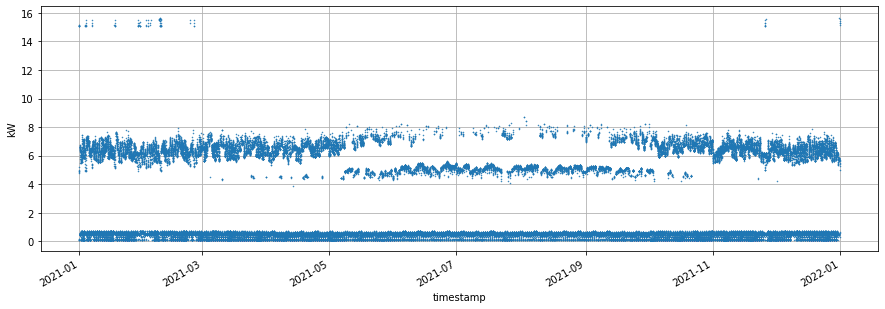

In [9]:
plot(load("house.csv"))

The result looks good.  We can clearly see the heating system running in both `HEAT` and `AUX` mode during the winter, the cooling system running in the summer at lower power, and the appliances running periodically.

Close inspection of the CSV data reveals a common problem for data analysis, i.e., the data is collected at irregular intervals:

In [10]:
!head house.csv

timestamp,panel.power
2021-01-01T00:00:00-07:00,+0.182797+0.039426j
2021-01-01T00:00:11-07:00,+4.820062+0.039426j
2021-01-01T00:11:07-07:00,+15.154728+0.039426j
2021-01-01T01:00:00-07:00,+15.092892+0.029054j
2021-01-01T01:10:53-07:00,+0.120960+0.029054j
2021-01-01T01:14:13-07:00,+4.853393+0.029054j
2021-01-01T01:40:40-07:00,+15.092892+0.029054j
2021-01-01T02:00:00-07:00,+15.071186+0.025780j
2021-01-01T02:28:59-07:00,+0.099254+0.025780j


In the next model we will see how to address this problem.

# Metering
The solution to irregular sampling is to measure the total cumulative energy use at regular intervals, e.g., 15 minutes, and take the difference with the previous observation.  This is called interval metering in the utility industry, and this precisely what the GridLAB-D meter objects do, as illustrated in the following model:

In [11]:
!cat meter.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${STARTTIME:-"2021-01-01 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
	implicit_enduse_source RBSA2014;	
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120 V;
	measured_energy_delta_timestep ${SAMPLETIME:-900};
	object house
	{
		floor_area ${FLOORAREA:-2500 sf};
	};
	object recorder
	{
		property "measured_real_energy_delta";
		file ${modelname/.glm/.csv};
		interval ${SAMPLETIME:-900};		
	};
}


In this model we have added a new parameter called `SAMPLETIME` that specifies how often samples are collected by the meter object and recorded in the CSV file.

In [12]:
!test meter.glm -nt meter.csv && gridlabd meter.glm

Now we see that the data is collected in regular interval, which makes analysis much easier:

In [13]:
!head meter.csv

timestamp,measured_real_energy_delta
2021-01-01T00:00:00-07:00,+0
2021-01-01T00:15:00-07:00,+45.6992
2021-01-01T00:30:00-07:00,+45.6992
2021-01-01T00:45:00-07:00,+1208.36
2021-01-01T01:00:00-07:00,+1223.69
2021-01-01T01:15:00-07:00,+1208.68
2021-01-01T01:30:00-07:00,+1631.74
2021-01-01T01:45:00-07:00,+3773.23
2021-01-01T02:00:00-07:00,+3773.23


<AxesSubplot:xlabel='timestamp', ylabel='kW'>

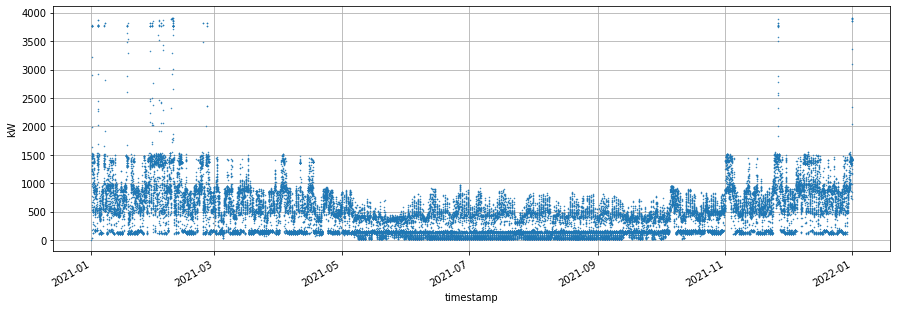

In [14]:
meter = load('meter.csv')
plot(meter)

From now on interval sampling will allow us to use a heatmap plot that shows consecutive days in separate rows or columns with time of day plotted on the other axis.

In [15]:
import PIL
def heatmap(panel,interval,day0=0,ndays=None,transpose=False):
    import PIL
    nsamples=int(86400/interval)
    if not ndays:
        ndays = int(len(panel.index)/nsamples-day0)
    data = numpy.array(panel['power'][nsamples*day0:nsamples*(day0+ndays)])
    data = numpy.reshape(data,(ndays,nsamples))/data.max()
    if transpose:
        print(f"Day (horizontal: {ndays} days) x Time (vertical: {interval} seconds/pixel)")
        data = data.transpose()
    else:
        print(f"Time (vertical: {interval} seconds/pixel) x Day (vertical: {ndays} days)")
    return PIL.Image.fromarray(numpy.uint8(data*255),'L')

Day (horizontal: 365 days) x Time (vertical: 900 seconds/pixel)


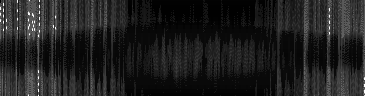

In [16]:
heatmap(meter,900,transpose=True)

# Service Transformer
Typically more than one house is served by a single service transformer.  The following model provides the observed load for 4 homes on a single service transformer sampled at 1 minute intervals.

In [17]:
!cat transformer.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${STARTTIME:-"2021-01-01 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
	implicit_enduse_source RBSA2014;
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep ${SAMPLETIME:-60};
	object house:..${NHOMES:-4}
	{
		floor_area random.triangle(${FLOORAREA_MIN:-1000},${FLOORAREA_MAX:-3000});
	};
	object recorder
	{
		property "measured_real_energy_delta";
		file ${modelname/.glm/.csv};
		interval ${SAMPLETIME:-60};		
	};
}


In this model we have added three new parameters:
- `NHOMES` which specifies how many homes we will simulate;
- `FLOORAREA_MIN` which specifies the minimum floor area to use in the randomly generated sample of homes
- `FLOORAREA_MAX` which specifies the maximum floor area to use in the randomly generated sample of homes

In [18]:
!test transformer.glm -nt transformer.csv && gridlabd transformer.glm

The simulation takes longer to run because it has more objects that need to be updated synchronously.  For larger models, we can run shorter duration simulation, use parallelization, or limit when synchronous updates of loads take place. For this example, we will simply allow the full simulation to run as above.

<AxesSubplot:xlabel='timestamp', ylabel='kW'>

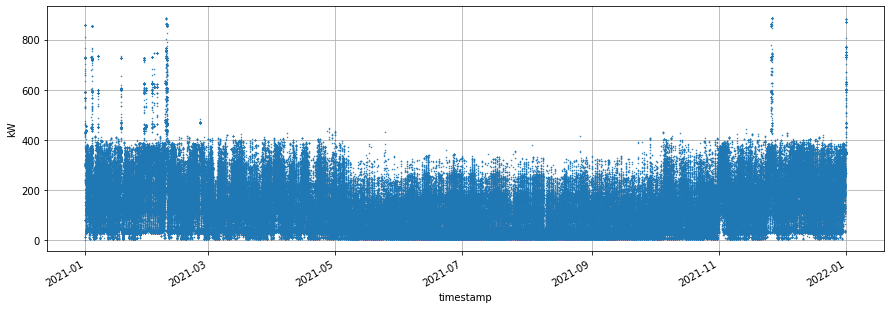

In [19]:
transformer = load('transformer.csv')
plot(transformer)

Time (vertical: 60 seconds/pixel) x Day (vertical: 365 days)


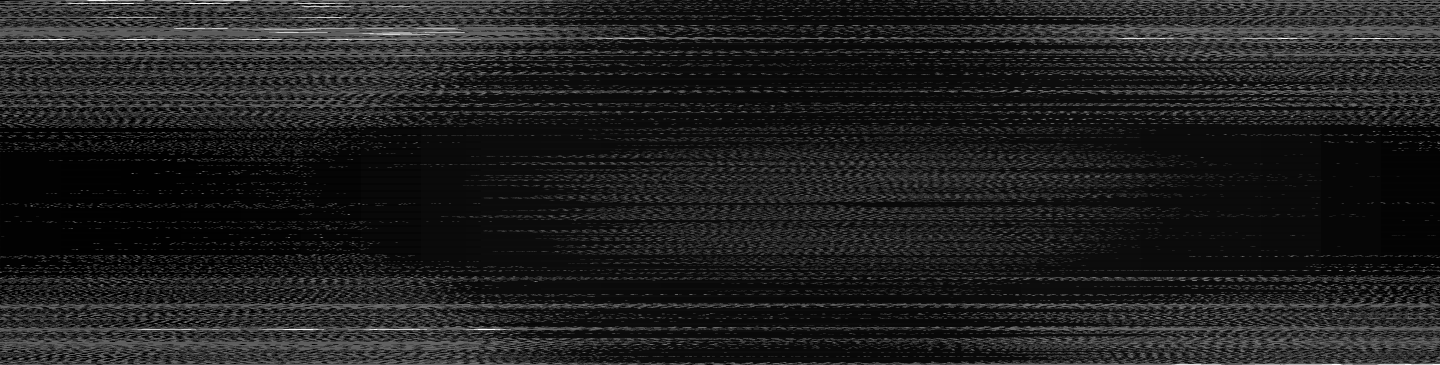

In [20]:
heatmap(transformer,60)

# Feeder
At the feeder level, the total load might include more than a hundred homes. Note that the model does not include line losses between the feeder and the homes. In addition, the data collection is performed at the rate of SCADA, i.e., 4 seconds per sample, instead of AMI's 15 minutes per sample.

Because the number of homes is so large, the annual simulation takes much longer this run is shortened to a single week just to illustrate the result.

In [21]:
!cat feeder.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${STARTTIME:-"2021-01-01 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
	implicit_enduse_source RBSA2014;	
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep ${SAMPLETIME:-4};
	object house:..${NHOMES:-20}
	{
		floor_area random.triangle(${FLOORAREA_MIN:-1000},${FLOORAREA_MAX:-3000});
		thermal_integrity_level BELOW_NORMAL;
		motor_efficiency VERY_POOR;
		fan_type ONE_SPEED;
	};
	object house:..${NHOMES:-20}
	{
		floor_area random.triangle(${FLOORAREA_MIN:-1000},${FLOORAREA_MAX:-3000});
		thermal_integrity_level NORMAL

In [22]:
!test feeder.glm -nt feeder.csv && gridlabd -D STOPTIME="2021-02-01 00:00:00 MST" feeder.glm

<AxesSubplot:xlabel='timestamp', ylabel='kW'>

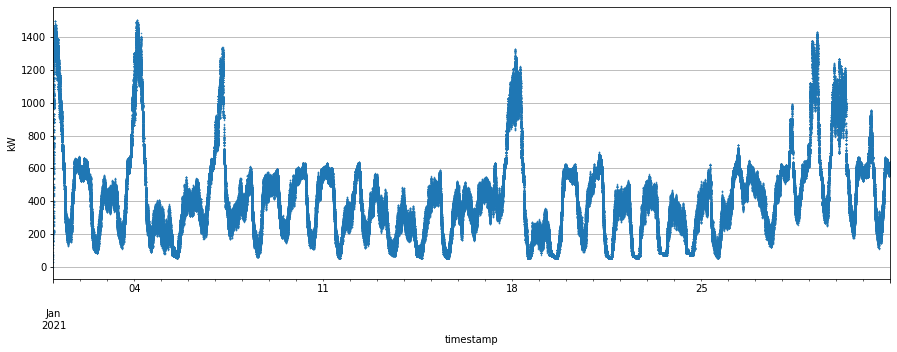

In [23]:
feeder = load('feeder.csv')
plot(feeder)

# Substation
The substation model has many more homes and can take much longer to run. An initialization period has been added to avoid sampling during the initialization transient.

In [24]:
!cat substation.glm

clock
{
	timezone ${TIMEZONE:-"MST+7MDT"};
	starttime ${INITTIME:-"2020-12-26 00:00:00 MST"};
	stoptime ${STOPTIME:-"2022-01-01 00:00:00 MST"};
}
#weather get ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"}
#input ${WEATHER:-"CO-Denver_Intl_Ap.tmy3"} -p interpolate=QUADRATIC
module residential
{
	implicit_enduses ${ENDUSES:-DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS};
	implicit_enduse_source RBSA2014;
}
module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
#set complex_format="%+.6f%+.6fj"
module powerflow;
object triplex_meter
{
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep ${SAMPLETIME:-4};
	object house:..${NHOMES:-100}
	{
		floor_area random.triangle(${FLOORAREA_MIN:-1000},${FLOORAREA_MAX:-3000});
		thermal_integrity_level BELOW_NORMAL;
		motor_efficiency VERY_POOR;
		fan_type ONE_SPEED;
	};
	object house:..${NHOMES:-100}
	{
		floor_area random.triangle(${FLOORAREA_MIN:-1000},${FLOORAREA_MAX:-3000});
		thermal_integrity_level NORMAL

In [25]:
!test substation.glm -nt substation.csv && gridlabd substation.glm

<AxesSubplot:xlabel='timestamp', ylabel='kW'>

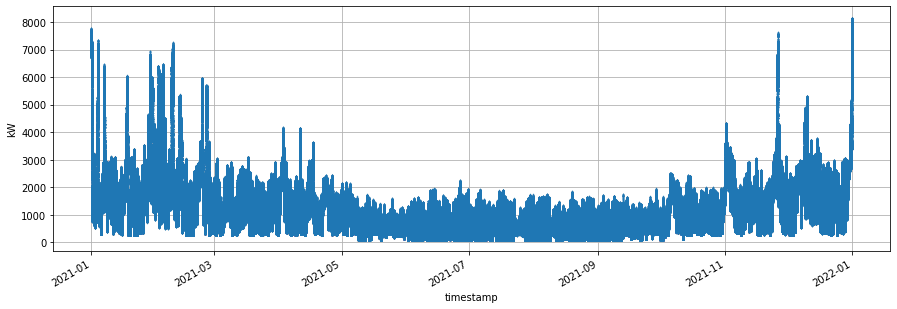

In [26]:
substation = load('substation.csv')
plot(substation)

Here's a greyscale plot of the day of year plotted horizontally, and time of day plotted vertically.

Day (horizontal: 365 days) x Time (vertical: 300 seconds/pixel)


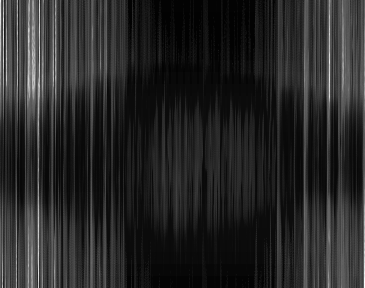

In [27]:
interval = 300
substation['period'] = ((substation.index-substation.index[0])/interval/1e9).astype('int32')
downsample = substation.groupby('period').mean()
heatmap(downsample,interval,transpose=True)